# How bad is the air in two major cities in China: Shanghai & Beijing?
Considering how many days of the year that Beijing consistently is higher than the WHO standard for air quality, what days does it actually fall below the WHO standard and what days does Sha@nghai's number of PM 2.5 exceed Beijing's, signifying worse air?


In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns
from re import sub
from decimal import Decimal
from io import StringIO
    
%matplotlib notebook

In [2]:
#returns the string of a column
def string_name_col(data):
    df = data
    n_string = []
    for index, row in df.iterrows():
        new_string = row['Date (LST)'].strftime("%x %X")
        n_string.append(new_string)
    return n_string

In [3]:
#data extraction for aqi in Shanghai found: http://www.stateair.net/web/historical/1/4.html
df_sh = pd.read_excel('Shanghai_2017.xlsx', sheetname="Shanghai_2017_HourlyPM25_create")
df_sh = df_sh.iloc[2:] 
df_sh = df_sh.reset_index(drop=True)
df_sh.columns = df_sh.iloc[0]
df_sh = df_sh.iloc[1:]

list_to_drop = []
drop_number = 1
for index, row in df_sh.iterrows():
    if row['QC Name'] == 'Missing':
        list_to_drop.append(drop_number)
    drop_number += 1

df_sh = df_sh.drop(list_to_drop)
df_sh = df_sh.reset_index(drop=True)
df_sh['Date (LST)'] = string_name_col(df_sh)
df_sh = df_sh.drop(df_sh.columns[[0, 1, 3, 4, 5, 6, 8, 9, 10]], axis=1)
df_sh = df_sh.rename(columns={'Value': 'PM2.5'})
df_sh.head()

,Date (LST),PM2.5
0,01/01/17 00:00:00,42
1,01/01/17 01:00:00,46
2,01/01/17 02:00:00,56
3,01/01/17 03:00:00,49
4,01/01/17 04:00:00,51


In [4]:
#data extraction for aqi in Beijing found: http://www.stateair.net/web/historical/1/4.html
df_bj = pd.read_excel('Beijing_2017.xlsx', sheetname="Beijing_2017_HourlyPM25_created")
df_bj = df_bj.iloc[2:] 
df_bj = df_bj.reset_index(drop=True)
df_bj.columns = df_bj.iloc[0]
df_bj = df_bj.iloc[1:]

list_to_drop_bj = []
drop_number_bj = 1
for index, row in df_bj.iterrows():
    if row['QC Name'] == 'Missing':
        list_to_drop_bj.append(drop_number_bj)
    drop_number_bj += 1

df_bj = df_bj.drop(list_to_drop_bj)
df_bj = df_bj.reset_index(drop=True)
df_bj['Date (LST)'] = string_name_col(df_bj)
df_bj = df_bj.drop(df_bj.columns[[0, 1, 3, 4, 5, 6, 8, 9, 10]], axis=1)
df_bj = df_bj.rename(columns={'Value': 'PM2.5'})
df_bj.head()

,Date (LST),PM2.5
0,01/01/17 00:00:00,505
1,01/01/17 01:00:00,485
2,01/01/17 02:00:00,466
3,01/01/17 03:00:00,435
4,01/01/17 04:00:00,405


In [5]:
df_bj.tail()

,Date (LST),PM2.5
4311,06/30/17 19:00:00,51
4312,06/30/17 20:00:00,68
4313,06/30/17 21:00:00,61
4314,06/30/17 22:00:00,49
4315,06/30/17 23:00:00,55


In [6]:
#Hours, months and days should be zero-padded

#Hours
def zerohour(matchobj):
    return " 0" + matchobj.group(0)[1:]
df_sh["Date (LST)"] = df_sh["Date (LST)"].apply(lambda l: re.sub(r' [1-9]:', zerohour, l))
df_bj["Date (LST)"] = df_bj["Date (LST)"].apply(lambda l: re.sub(r' [1-9]:', zerohour, l))

#Months and days
def zeroday(matchobj):
    return "/0" + matchobj.group(0)[1:]
def zeromonth(matchobj):
    return " 0" + matchobj.group(0)[1:]

df_sh["Date (LST)"] = df_sh["Date (LST)"].apply(lambda l: re.sub(r'/[1-9]/', zeroday, l))
df_sh["Date (LST)"] = df_sh["Date (LST)"].apply(lambda l: re.sub(r' [1-9]/', zeromonth, l))

df_bj["Date (LST)"] = df_bj["Date (LST)"].apply(lambda l: re.sub(r'/[1-9]/', zeroday, l))
df_bj["Date (LST)"] = df_bj["Date (LST)"].apply(lambda l: re.sub(r' [1-9]/', zeromonth, l))

In [7]:
#A date_index object that will be used for several tasks
date_index_sh = pd.DatetimeIndex(df_sh['Date (LST)'])
date_index_bj = pd.DatetimeIndex(df_bj['Date (LST)'])

#The main index will be the Month-Day combination
df_sh["Year"] = date_index_sh.year
df_sh["Month"] = date_index_sh.month
df_sh["Day"] = date_index_sh.day

df_bj["Year"] = date_index_bj.year
df_bj["Month"] = date_index_bj.month
df_bj["Day"] = date_index_bj.day

#The spaces at the end of the PM2.5 values also cause problems at parsing
df_sh["PM2.5"] = pd.to_numeric(df_sh["PM2.5"])

df_bj["PM2.5"] = pd.to_numeric(df_bj["PM2.5"])

#The daily 24-hours mean
df_sh_mean = df_sh.groupby(["Year", "Month", "Day"])["PM2.5"].mean()
df_bj_mean = df_bj.groupby(["Year", "Month", "Day"])["PM2.5"].mean()
df_bj_mean

Year  Month  Day
2017  1      1      476.916667
             2      219.333333
             3      357.541667
             4      401.250000
             5      229.416667
             6      237.833333
             7      188.375000
             8       20.916667
             9       38.913043
             10      30.000000
             11      67.565217
             12      43.166667
             13      10.041667
             14      18.916667
             15      51.375000
             16     102.250000
             17     149.541667
             18      45.500000
             19      52.791667
             20      22.583333
             21      33.291667
             22      29.125000
             23      42.916667
             24     107.541667
             25     198.333333
             26     186.875000
             27      64.291667
             28     286.588235
             29      48.666667
             30      30.125000
                       ...    
      6      1       2

In [8]:
#World Health Organization's Air Quality Guideline limits (24-hour mean)
#http://apps.who.int/iris/bitstream/10665/69477/1/WHO_SDE_PHE_OEH_06.02_eng.pdf
legal_pm2 = 25
%matplotlib inline
mpl.rcParams['figure.figsize'] = (18, 10)

In [9]:
#x-axis array: daily from 1 Jan 2017 to 30 June 2017
observation_axis = np.arange('2017-01-01', '2017-07-01', dtype='datetime64[D]')
observation_axis = np.array(list(map(pd.to_datetime, observation_axis)))

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


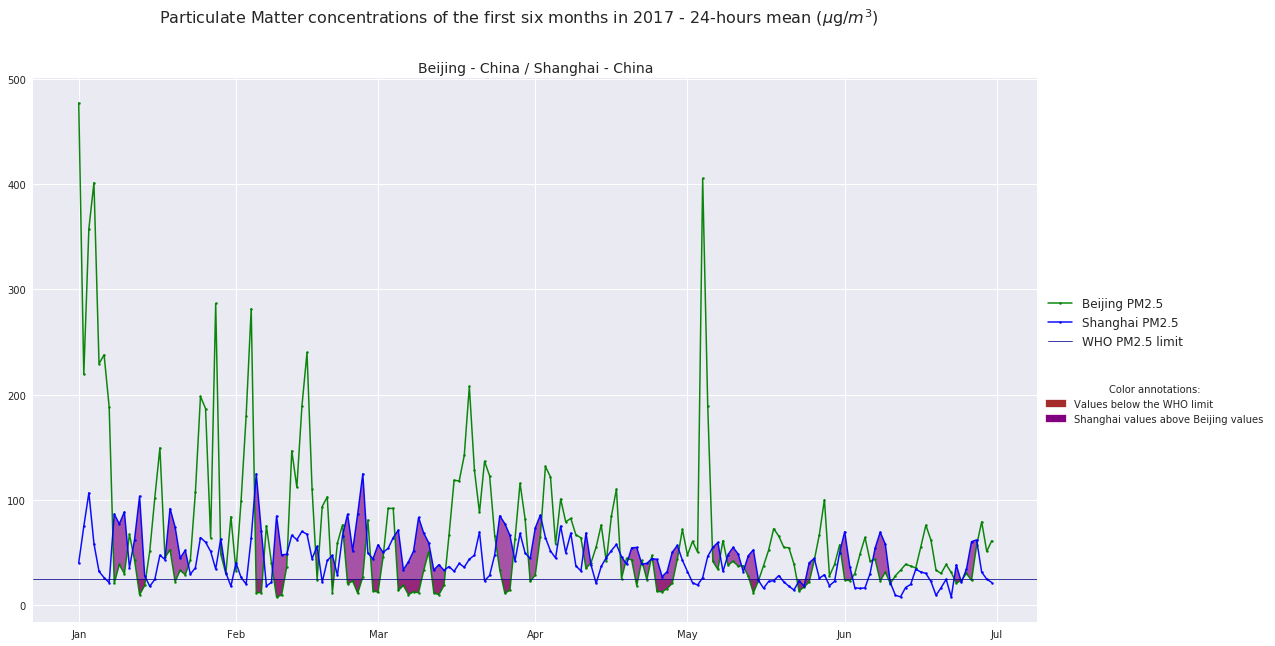

In [10]:
#Title
plt.suptitle("Particulate Matter concentrations of the first six months in 2017 - 24-hours mean ($\mu$g/$m^3$)", fontsize=16)
plt.title("Beijing - China / Shanghai - China", fontsize=14)

#PM measures: 24-hours mean
#Beijing
plt.plot(observation_axis, df_bj_mean.as_matrix(), '-o', ms=2.5, alpha=0.95, color = 'green', linewidth=1.5) 
#Shanghai
plt.plot(observation_axis, df_sh_mean.as_matrix(), '-o', ms=2.5, alpha=0.95, color='blue', linewidth=1.5) 

#WHO Guidelines
plt.axhline(y=legal_pm2, color='darkblue', linestyle='-', linewidth=0.75)

#X-axis: months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

#First legend: lines
first_legend = plt.legend(['Beijing PM2.5', 'Shanghai PM2.5', 'WHO PM2.5 limit'], 
                          loc='center left', bbox_to_anchor=(1.0, 0.55), prop={'size':12})
plt.gca().add_artist(first_legend)

#Second legend: color annotations
import matplotlib.patches as mpatches
patches = [ mpatches.Patch(color='brown', label='Values below the WHO limit'), 
           mpatches.Patch(color='purple', label='Shanghai values above Beijing values'),
          ]
plt.legend(handles=patches, loc='center left', bbox_to_anchor=(1.0, 0.4), prop={'size':10}, title="Color annotations:")

#When Beijing measures exceed WHO limits
plt.gca().fill_between(observation_axis, legal_pm2, df_bj_mean, where=df_bj_mean<=legal_pm2, 
                       interpolate=True, facecolor='brown', alpha=0.65)

#When Shanghai measures exceed those of Beijing
plt.gca().fill_between(observation_axis, df_bj_mean, df_sh_mean, where=df_sh_mean>df_bj_mean, 
                       interpolate=True, facecolor='purple', alpha=0.65)
